In [1]:
#Initial configuration, probably overkill in imports.
import sys, os, re
import numpy as np
import allel
import zarr
import dask
import numcodecs
import warnings
from pathlib import Path

#os.environ["MODIN_ENGINE"] = "ray"

#import modin.pandas as pd
import pandas as pd

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from horizonplot import horizonplot
import seaborn as sns
sns.set()
sns.set_theme()
sns.set_style("white")
sns.set_context("notebook")

In [2]:
meta_data_samples = pd.read_table("../data/meta_data_samples.txt", sep = " ")

In [3]:
#Opening the zarr data
callset = zarr.open_group('/faststorage/project/primatediversity/people/kmt/baboon_flagship/steps/callset.zarr', mode='r')
callset.tree(expand=False)

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='chr1', nodes=(Node(disabled=True, n…

In [4]:
females = meta_data_samples.loc[(meta_data_samples.Sex == "F")& (meta_data_samples.PGDP_ID != "PD_0202")].callset_index.values
males = meta_data_samples.loc[(meta_data_samples.Sex == "M")].callset_index.values

In [5]:
print(len(males), len(females))

96 63


In [6]:
pos = allel.SortedIndex(callset['chrX/variants/POS'])
loc_region = pos.locate_range(3000000, 152000000)

In [7]:
gt_zarr = callset["chrX/calldata/GT"]
gt = allel.GenotypeArray(gt_zarr[loc_region])

In [8]:
gt_females = (gt.take(females, axis=1))
gt_males = (gt.take(males, axis=1))
ac_female = gt_females.count_alleles(max_allele=1)[:]
ac_male = gt_males.count_alleles(max_allele=1)[:]

In [9]:
het_females = allel.GenotypeAlleleCounts(ac_female).is_het()
het_males = allel.GenotypeAlleleCounts(ac_male).is_het()

In [10]:
print(len(het_males), len(het_females))

3411081 3411081


In [11]:
union = np.logical_and(
    np.logical_and(het_males != False, het_females != False),
    het_males == het_females).sum()

In [12]:
#Number of het sites on the X
print(het_males.sum(), het_females.sum(), union)
# 2256621 and 2106141

2098496 1967201 1527420


In [13]:
#Number of singletons
print(ac_female.count_singleton(), ac_male.count_singleton())
print(ac_female.count_singleton()/het_females.sum(), ac_male.count_singleton()/het_males.sum())

410490 81273
0.20866703504115747 0.03872916603129098


In [14]:
#Number of doubletons
print(ac_female.count_doubleton(), ac_male.count_doubleton())
print(ac_female.count_doubleton()/het_females.sum(), ac_male.count_doubleton()/het_males.sum())

237653 441792
0.12080768564066408 0.21052792094909878


In [15]:
#male_list = het_males.tolist()
#female_list = het_females.tolist()
print(len(het_males))

3411081


In [16]:
union = 0
male_unique = 0
female_unique = 0
no_het = 0
for i in range(len(het_females)):
    if het_males[i] == True and het_females[i] == True:
        union += 1
    elif het_females[i] == True:
        female_unique += 1
    elif het_males[i] == True:
        male_unique += 1
    else:
        no_het += 1

In [17]:
print(union, male_unique, female_unique, no_het)

1527420 571076 439781 872804


In [18]:
print("{} % of male het calls are not male unique".format(union/het_males.sum()))
print("{} % of male het calls are male unique".format(male_unique/het_males.sum()))
print("{} % of female het calls are female unique".format(female_unique/het_females.sum()))

0.7278641465125499 % of male het calls are not male unique
0.27213585348745006 % of male het calls are male unique
0.2235567184034575 % of female het calls are female unique


In [28]:
#Looking at het for all males
all_het_males = gt_males.compress(het_males, axis=0)

In [138]:
het_l=[0]*all_het_males.n_samples
c_l = list(range(all_het_males.n_samples))
for i in range(len(all_het_males)):
    c = all_het_males[i].count_het()
    het_l[c-1] += 1

In [53]:
het_l[all_het_males.n_samples-1]/het_males.sum() #86,8 % are het in all males, indicating fixed differences

0.8684238616609229

In [61]:
d={"het_l": het_l, "i": c_l}
df_males = pd.DataFrame(data=d)

In [69]:
df_males["het_percentage"]= df_males["het_l"]/het_males.sum()

In [71]:
df_males

,het_l,i,het_percentage
0,0.044802,0,2.134939e-08
1,0.016397,1,7.813910e-09
2,0.009303,2,4.433105e-09
3,0.006110,3,2.911652e-09
4,0.004491,4,2.140026e-09
...,...,...,...
91,0.000434,91,2.068722e-10
92,0.000584,92,2.781761e-10
93,0.000508,93,2.422971e-10
94,0.000671,94,3.199593e-10


<AxesSubplot:xlabel='i', ylabel='het_percentage'>

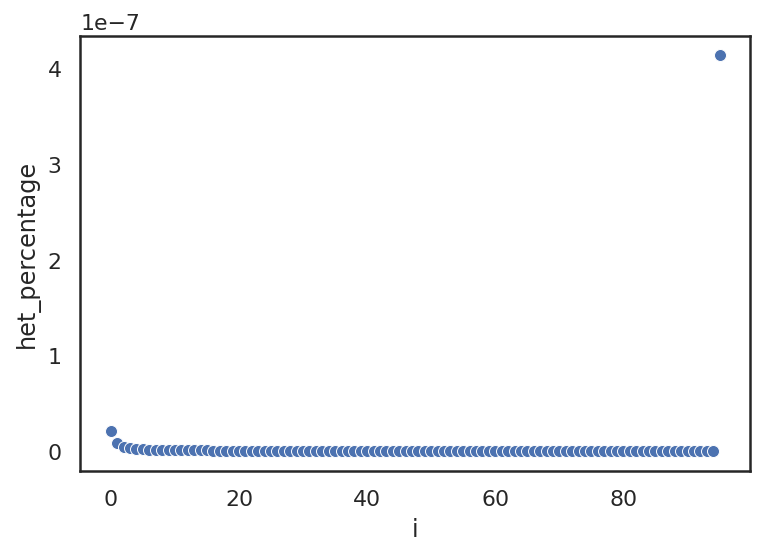

In [70]:
sns.scatterplot(data = df_males, x="i", y="het_percentage")

In [54]:
#Doing the same for females
all_het_females = gt_females.compress(het_females, axis=0)

In [56]:
#Doing the same for females
all_het_females = gt_females.compress(het_females, axis=0)
het_l_females=[0]*all_het_females.n_samples
c_l_females = list(range(all_het_females.n_samples))
for i in range(len(all_het_females)):
    c = all_het_females[i].count_het()
    het_l_females[c-1] += 1

In [72]:
het_l_females[all_het_females.n_samples-1]/het_females.sum()

0.08463192119158133

In [77]:
print(len(het_l_females), len(c_l_females))

63 63


In [80]:
d={"het_l": het_l_females, "i": c_l_females}
df_females = pd.DataFrame(data=d)
df_females["het_percentage"]= df_females["het_l"]/het_females.sum()

In [82]:
df_females

,het_l,i,het_percentage
0,523595,0,0.266162
1,321364,1,0.163361
2,209309,2,0.106399
3,151813,3,0.077172
4,119854,4,0.060926
...,...,...,...
58,207,58,0.000105
59,175,59,0.000089
60,133,60,0.000068
61,97,61,0.000049


<AxesSubplot:xlabel='i', ylabel='het_percentage'>

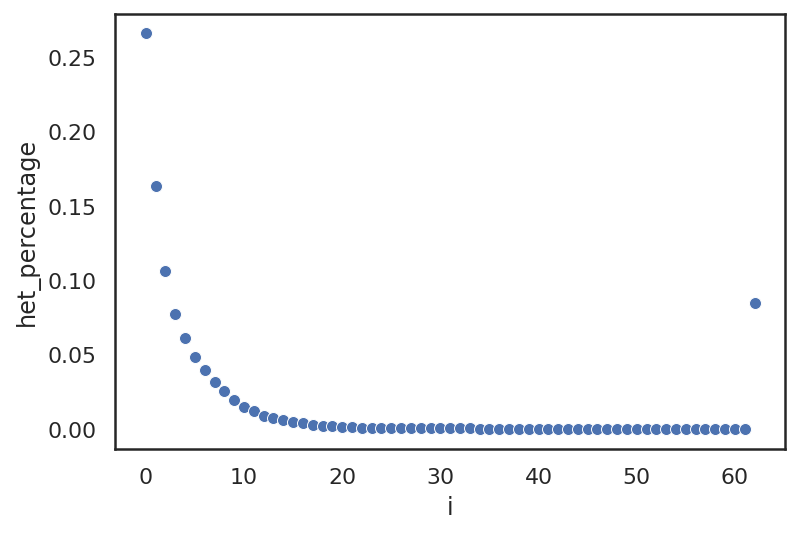

In [81]:
sns.scatterplot(data = df_females, x="i", y="het_percentage")

#There is something weird with the numbers (all should have the least shared hets)
#I think it is a problem with is_het or count_het,
#so I will check that by looking at all individuals in papio individually

papio = meta_data_samples.loc[(meta_data_samples.Species == "papio") & 
                                  (meta_data_samples.Sex == "M")].callset_index.values
for i in papio:
    gt_i = gt.take([i]+[1], axis=1)
    ac = gt_i.count_alleles(max_allele=1)[:]
    het_i = allel.GenotypeAlleleCounts(ac).is_het()
    all_het_i = gt_i.compress(het_i, axis=0)
    het_l=[0]*gt_i.n_samples
    c_l = list(range(gt_i.n_samples))
    for i in range(len(all_het_i)):
        c = all_het_i[i].count_het()
        het_l[c-1] += 1
    print(het_l)
    print(het_l[gt_i.n_samples-1], sum(het_l), het_l[gt_i.n_samples-1]/sum(het_l))
#It is hard for me to visually detect what goes wrong - is_het and count_het both seem to work as expected
#Answer: Is_het was based on allele counts, and therefore took alleles with 1ref/1alt as het.
#Saving this code for posteority


In [198]:
#Function to look at shared heterozygosity across species, male
n = []
all_het = []
species_l = meta_data_samples.Species.unique().tolist()
species_l.append("all")
d_spectrum = {}
for species in species_l:
    #Filtering for individuals
    if species == "all":
        s = meta_data_samples.loc[(meta_data_samples.Sex == "M")].callset_index.values
    else:
        s = meta_data_samples.loc[(meta_data_samples.Species == species) & 
                                  (meta_data_samples.Sex == "M")].callset_index.values
    gt_species = gt.take(s, axis=1)
    #Filtering for biallelic
    ac = gt_species.count_alleles()[:]
    flt = (ac.max_allele() == 1)
    gf = gt_species.compress(flt, axis=0)
    #is_het returns a 2x2 ndarray, for each pos/indvididual combination. True=het.
    het_or_not = gf.is_het()
    het_l=[0]*(gt_species.n_samples+1)
    c_l = list(range(gt_species.n_samples+1))
    for i in range(len(het_or_not)):
        c = het_or_not[i].sum()
        het_l[c] += 1
    n.append(gt_species.n_samples)
    print(het_l)
    d_spectrum[species+"_M"] = het_l
    print(sum(het_l), het_l[gt_species.n_samples]/sum(het_l[1:]))
    all_het.append(het_l[gt_species.n_samples]/sum(het_l[1:]))
    print(species)
d={"shared_het": all_het, "n_individuals": n, "species": species_l}
df_species_male = pd.DataFrame(data=d)
df_species_male["sex"]="M"

[1671094, 49682, 17879, 10262, 7226, 5310, 4126, 3654, 2963, 2794, 2451, 2318, 2172, 2248, 2148, 2165, 2130, 2129, 2354, 2663, 2817, 3539, 4387, 7978]
1816489 0.054871212902782074
anubis
[2010016, 68565, 23875, 13452, 9488, 7104, 5303, 4559, 3569, 3275, 3021, 2852, 2593, 2459, 2238, 2234, 2059, 1806, 1779, 1815, 1823, 1967, 1889, 1800, 2020, 2115, 2171, 2565, 2946, 4829]
2196187 0.0259385188885487
cynocephalus
[1377838, 32501, 13888, 9353, 8074, 7124, 7873, 16414]
1473065 0.17236708076490911
papio
[1175415, 39504]
1214919 1.0
ursinus (grayfoot)
[1562706, 37124, 15020, 9128, 6147, 4897, 3791, 3344, 2999, 2750, 2716, 2553, 2395, 2622, 2546, 2605, 3028, 3569, 4770, 10618]
1685328 0.08659131314119815
hamadryas
[1626271, 30869, 12945, 8008, 6602, 5012, 4157, 3557, 3262, 2784, 2722, 2810, 2682, 2787, 3027, 3815, 3677, 8003]
1732990 0.07499133237755226
kindae
[2692725, 93377, 33640, 18983, 12431, 9131, 7253, 6202, 4896, 4220, 3624, 3147, 2854, 2630, 2277, 2078, 1968, 1816, 1706, 1656, 1493, 1

<AxesSubplot:xlabel='n_individuals', ylabel='shared_het'>

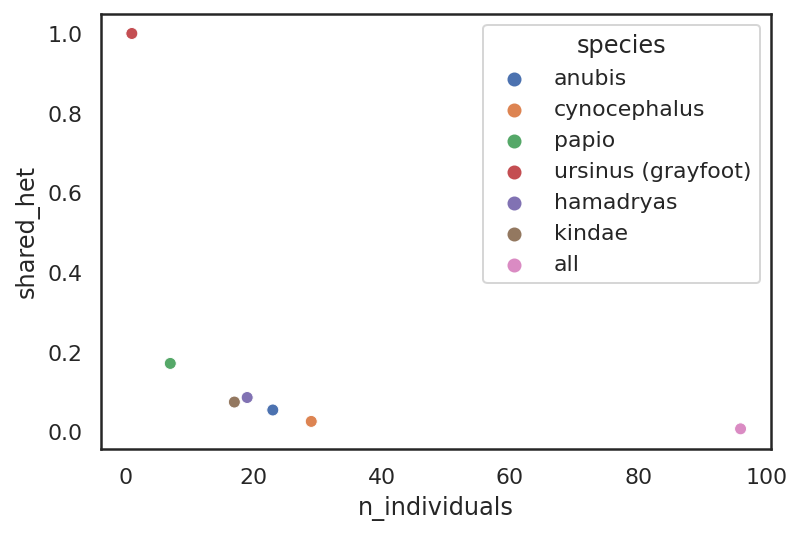

In [194]:
sns.scatterplot(data = df_species_male, x="n_individuals", y="shared_het", hue="species")

<AxesSubplot:xlabel='i', ylabel='het_counts'>

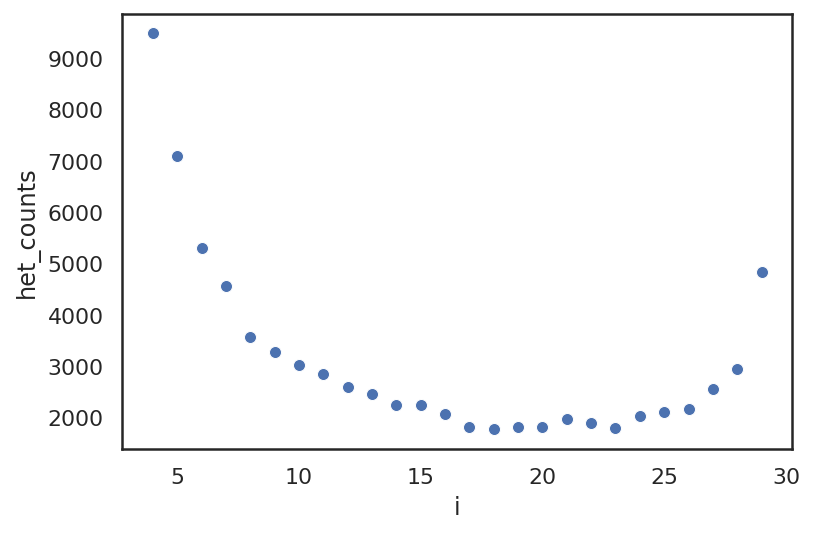

In [211]:
df_cyn = {"het_counts": d_spectrum["cynocephalus_M"][4:], "i": list(range(4, len(d_spectrum["cynocephalus_M"])))}
df_cyn = pd.DataFrame(data=df_cyn)
sns.scatterplot(data = df_cyn, x="i", y="het_counts")

In [199]:
#Same code, but for females
n = []
het = []

for species in species_l:
    if species == "all":
        s = meta_data_samples.loc[(meta_data_samples.Sex == "F") &
                                  (meta_data_samples.PGDP_ID != "PD_0202")].callset_index.values
    else:
        s = meta_data_samples.loc[(meta_data_samples.Species == species) & 
                                  (meta_data_samples.Sex == "F") &
                                  (meta_data_samples.PGDP_ID != "PD_0202")].callset_index.values
    gt_species = gt.take(s, axis=1)
    #Filtering for biallelic
    ac = gt_species.count_alleles()[:]
    flt = (ac.max_allele() == 1)
    gf = gt_species.compress(flt, axis=0)
    #is_het returns a 2x2 ndarray, for each pos/indvididual combination. True=het.
    het_or_not = gf.is_het()
    het_l=[0]*(gt_species.n_samples+1)
    c_l = list(range(gt_species.n_samples+1))
    for i in range(len(het_or_not)):
        c = het_or_not[i].sum()
        het_l[c] += 1
    n.append(gt_species.n_samples)
    print(het_l)
    d_spectrum[species+"_F"] = het_l
    print(sum(het_l), het_l[gt_species.n_samples]/sum(het_l[1:]))
    het.append(het_l[gt_species.n_samples]/sum(het_l[1:]))
    print(species)
d={"shared_het": het, "n_individuals": n, "species": species_l}
df_species_female = pd.DataFrame(data=d)
df_species_female["sex"]="F"

[1246355, 253437, 141070, 84961, 58795, 47690, 41033, 32099, 26019, 19661, 13539, 9595, 6819, 4947, 3010, 2093, 1452, 1189, 1013, 1000, 968, 850, 874, 815, 755, 732, 629, 377]
2001777 0.0004990588042180397
anubis
[1210389, 320754, 155849, 103411, 81482, 69501, 57102, 45991, 32465, 19605, 10830, 5003, 2640, 1782, 1387, 1073, 678]
2119942 0.0007454211024536229
cynocephalus
[1356474, 43435, 23511, 15071, 8721, 3763]
1450975 0.039819684447783624
papio
[1289643, 140972, 76265, 22136]
1529016 0.09247492407247267
ursinus (grayfoot)
[1294739, 138774, 84501, 47806, 21165, 5769]
1592754 0.01935808600238243
hamadryas
[1243379, 140834, 123661, 85869, 50261, 24958, 10904, 4467]
1684333 0.010130308376837493
kindae
[1233415, 522985, 319945, 207982, 150537, 118759, 94024, 77472, 61649, 49106, 38028, 28926, 23128, 17359, 13927, 10986, 8664, 7103, 5433, 4360, 3462, 2709, 2190, 1644, 1417, 1196, 1039, 938, 814, 716, 712, 615, 526, 534, 528, 481, 491, 447, 453, 416, 456, 427, 386, 360, 396, 360, 341, 331,

<AxesSubplot:xlabel='n_individuals', ylabel='shared_het'>

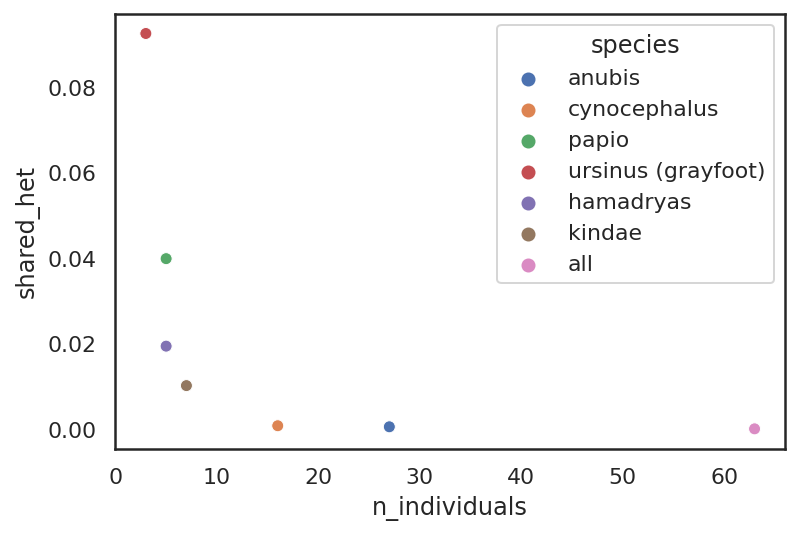

In [192]:
sns.scatterplot(data = df_species_female, x="n_individuals", y="shared_het", hue="species")